In [ ]:
from helper import split_name
from read_data import pull_data, prepare_data, get_expert_projections
from modeling import split_data_random, create_baseline, tune_xgb, create_model, generate_prediction_intervals, compile_predictions, combine_projections
from data_viz import plot_actual_vs_pred_mlb, plot_resid_vs_pred_mlb, plot_resid_hist_mlb, plot_decile_calib
from clean_and_cluster import assign_position_group, finalize_predictions, split_batters_if_of, create_draft_pool, calculate_relative_value, determine_optimal_k, segment_players
from config import BAT_POS_OVERRIDES, AGG_YEARS, SCORING_RULES, batting_stat_cols, pitching_stat_cols, batting_agg_cols, pitching_agg_cols, param_space, POS_DAMPENING_MAP
from xgboost import plot_importance
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

FORMAT = "DK" # <- Indicator for scoring format ("UD" for Underdog, "DK" for DraftKings, etc.)
START_YEAR = 2005 # <- Beginning season for data pull
END_YEAR = 2025 # <- Ending season for data pull, final model will predict following season
MODEL_WEIGHT = 0.67
PROJECTION_WEIGHT = 1 - MODEL_WEIGHT
ROSTER_SIZE = 20
LEAGUE_SIZE = 12
BONUS_PLAYER_POOL_MULT = 1.15
PITCHER_SPLIT = 0.34
BATTER_SPLIT_IF = 0.33
BATTER_SPLIT_OF = 0.33
SEED = 3200077

# URL of the FantasyPros projections page
batting_url = "https://www.fantasypros.com/mlb/projections/hitters.php"
pitching_url = "https://www.fantasypros.com/mlb/projections/pitchers.php"

C:\Users\jorda\Documents\development\baseball_modeling\.venv\Lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
player_pool = (ROSTER_SIZE * LEAGUE_SIZE) * BONUS_PLAYER_POOL_MULT
pitcher_pool = round(player_pool * PITCHER_SPLIT, 0)
batter_pool_if = round(player_pool * BATTER_SPLIT_IF, 0)
batter_pool_of = round(player_pool * BATTER_SPLIT_OF, 0)

In [3]:
# Pull data for batters & pitchers
batting_df, pitching_df = pull_data(
    start_year=START_YEAR,
    end_year=END_YEAR,
    agg_years=AGG_YEARS,
    batting_stat_cols=batting_stat_cols,
    pitching_stat_cols=pitching_stat_cols,
    batting_agg_cols=batting_agg_cols,
    pitching_agg_cols=pitching_agg_cols,
    career_window_years=10, # NOTE: as of 2025, career aggregates can only reach back 10 years in a single pull - rule in pybaseball
    fmt=FORMAT
)

# Prepare data for modeling
batting_df, pitching_df, batting_pred, pitching_pred = prepare_data(
    batting_df,
    pitching_df,
    pred_season=END_YEAR,
)

Loaded existing DK data files.


In [4]:
# TODO: Fix up n_estimators documentation
# TODO: Switch pitching model to RMSE-based?
# TODO: Code cleanup/organization

# Pulling FantasyPros Projection Data

In [5]:
batting_projections, pitching_projections = get_expert_projections(
    batting_url=batting_url,
    pitching_url=pitching_url,
    fmt=FORMAT,
    scoring_rules=SCORING_RULES,
)

# Creating Batting Model

## Creating baseline batting predictions

In [6]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data_random(batting_df, random_state=SEED)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

# Compiling baseline predictions
batting_comp = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_comp.head(10))

[Test] RMSE: 290.728 | MAE: 230.575 | R^2: 0.507 | Spearman: 0.703


,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
470,Jason Bay,1086.0,1535.097046,449.097046,449.097046,2006,27,1502.0
218,Albert Pujols,1828.0,1525.063477,-302.936523,302.936523,2008,28,1593.0
792,Alex Rodriguez,1539.0,1490.635498,-48.364502,48.364502,2005,29,1808.0
638,David Wright,1697.0,1478.463257,-218.536743,218.536743,2006,23,1496.0
169,David Wright,1264.0,1477.955200,213.955200,213.955200,2008,25,1641.0
399,Manny Machado,1412.0,1455.942993,43.942993,43.942993,2015,22,1477.0
252,Mark Teixeira,1279.0,1454.360718,175.360718,175.360718,2006,26,1471.0
502,Miguel Cabrera,1629.0,1445.701782,-183.298218,183.298218,2012,29,1657.0
134,David Ortiz,1168.0,1411.298462,243.298462,243.298462,2008,32,1029.0
571,Ryan Braun,512.0,1388.336914,876.336914,876.336914,2012,28,1685.0


# Building Batting Model

# Batting Predictions

In [7]:
# Tune model
best_params, best_iter = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=param_space,
    model_objective="reg:squarederror",
    metric="rmse",     
    evals=50,
    random_state=SEED,
    id_cols=["IDfg"],
)

# Generating prediction intervals via bootstrap-resampled models
batting_intervals = generate_prediction_intervals(
    X_train=x_train,
    y_train=y_train,
    X_pred=batting_pred.drop(columns=['fantasy_points_future']),
    base_params=best_params,
    model_objective="reg:squarederror",
    metric="rmse",
    n_bootstrap=40,
    random_state=SEED,
    id_cols=['IDfg', 'Name'],
    n_estimators=2000,
    early_stopping_rounds=100,
)

100%|██████████| 50/50 [02:59<00:00,  3.59s/trial, best loss: 275.07271055278403]
[Early stopping summary] mean=228, min=63, max=836
Best Parameters: {'learning_rate': 0.03413689719589855, 'max_leaves': 13, 'grow_policy': 'lossguide', 'subsample': 0.7909368020777966, 'colsample_bytree': 0.8861314255818868, 'min_child_weight': 3.0115918731732543, 'reg_lambda': 0.03364983755619944, 'reg_alpha': 1.1656471966397284, 'gamma': 0.002871015548058699}
[Best trial @ val] optimized=rmse | RMSE=275.073 | MAE=218.257 | R^2=0.535 | SPEAR=0.715 


Bootstrapping prediction intervals: 100%|██████████| 40/40 [01:37<00:00,  2.44s/it]


In [8]:
# Create final model
batting_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    n_estimators=best_iter,
    model_objective="reg:squarederror",
    metric="rmse",
    random_state=SEED,
    id_cols=["IDfg"],        
)

[Test] RMSE: 287.407 | MAE: 229.281 | R^2: 0.518 | SPEAR: 0.712


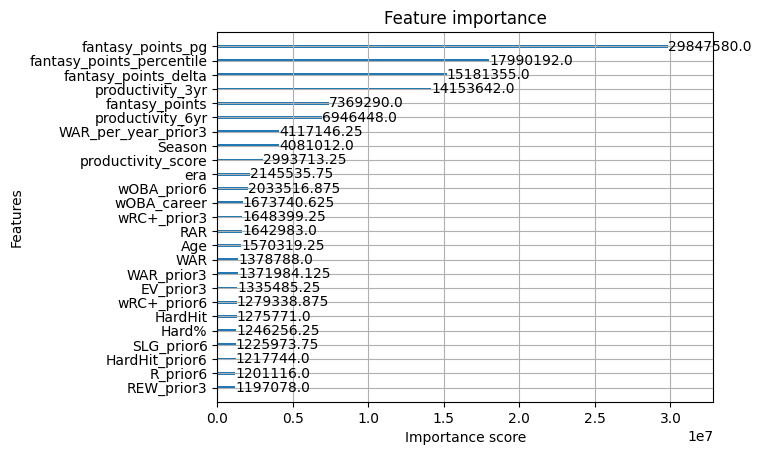

In [9]:
# Plot feature importance using XGBoost's built-in method
plot_importance(batting_model, importance_type="gain", max_num_features=25)
plt.show()

In [10]:
batting_results = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_results.head(10))

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
169,David Wright,1264.0,1460.166382,196.166382,196.166382,2008,25,1641.0
218,Albert Pujols,1828.0,1404.008789,-423.991211,423.991211,2008,28,1593.0
252,Mark Teixeira,1279.0,1397.775269,118.775269,118.775269,2006,26,1471.0
470,Jason Bay,1086.0,1387.291382,301.291382,301.291382,2006,27,1502.0
399,Manny Machado,1412.0,1382.008423,-29.991577,29.991577,2015,22,1477.0
638,David Wright,1697.0,1376.786865,-320.213135,320.213135,2006,23,1496.0
792,Alex Rodriguez,1539.0,1365.807495,-173.192505,173.192505,2005,29,1808.0
145,Austin Riley,844.0,1361.096802,517.096802,517.096802,2023,26,1454.0
502,Miguel Cabrera,1629.0,1353.089233,-275.910767,275.910767,2012,29,1657.0
744,Matt Holliday,1745.0,1349.772217,-395.227783,395.227783,2006,26,1581.0


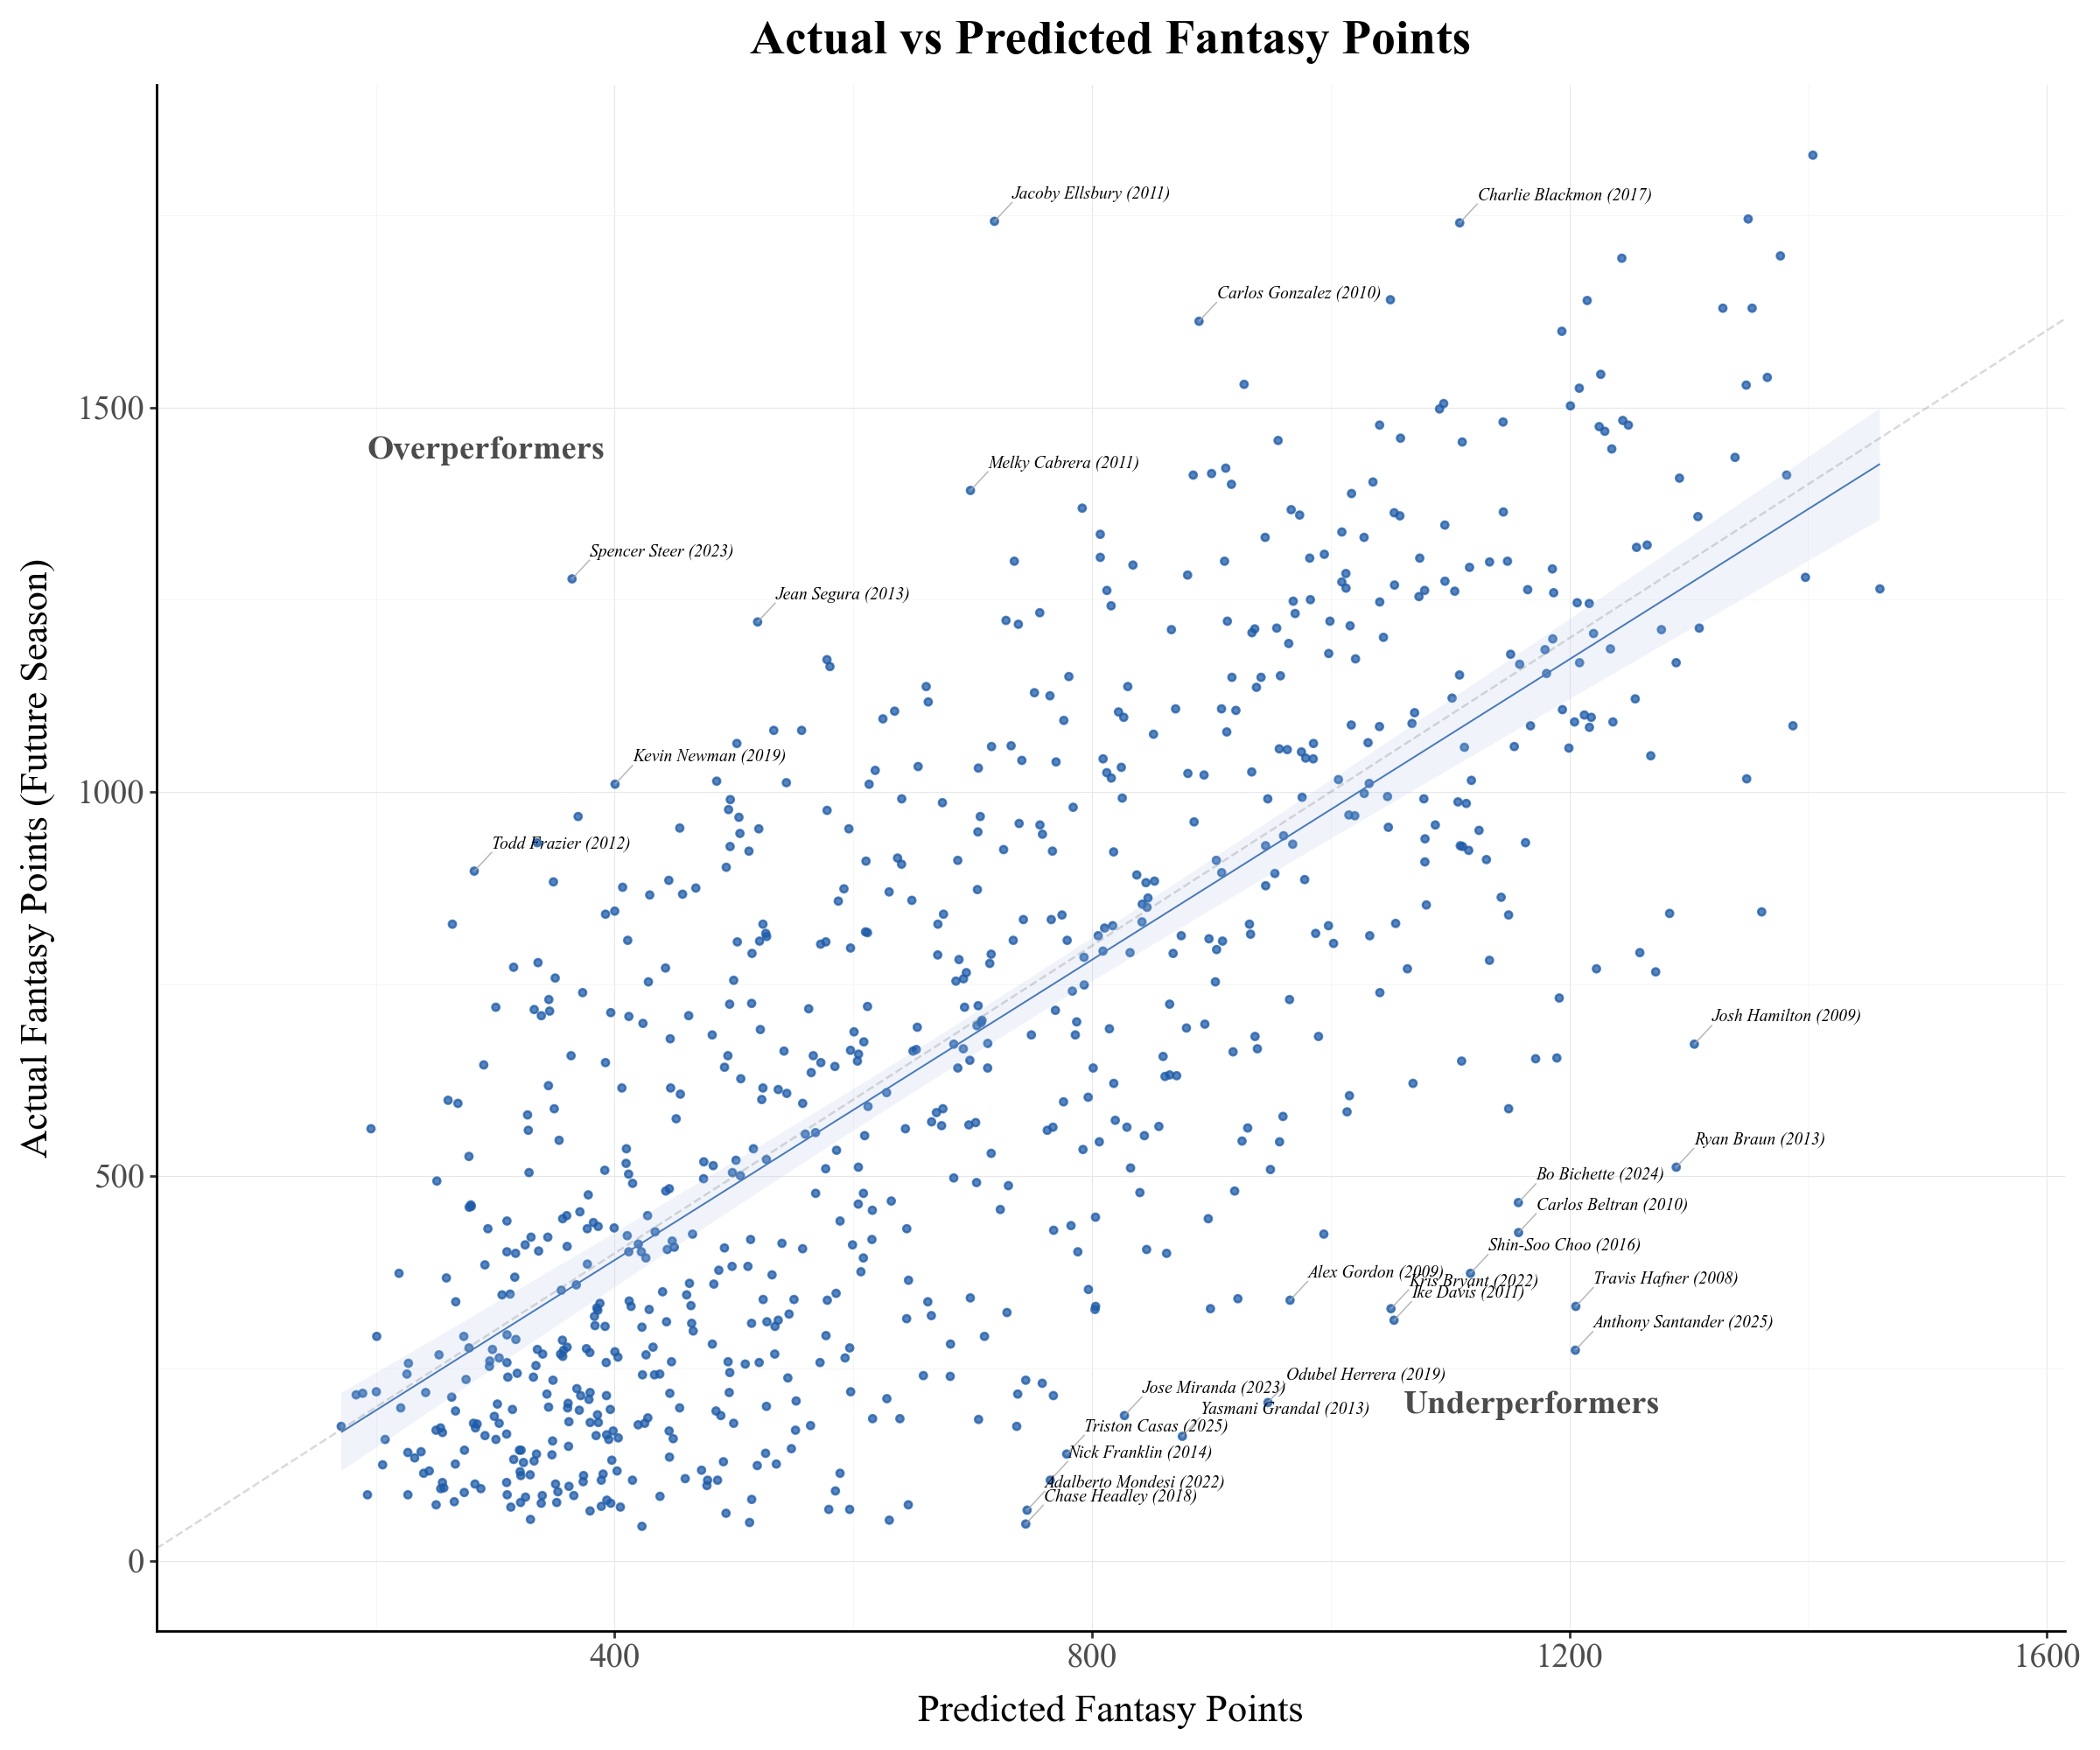

In [11]:
p1 = plot_actual_vs_pred_mlb(
    batting_results,
    top_n=25,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

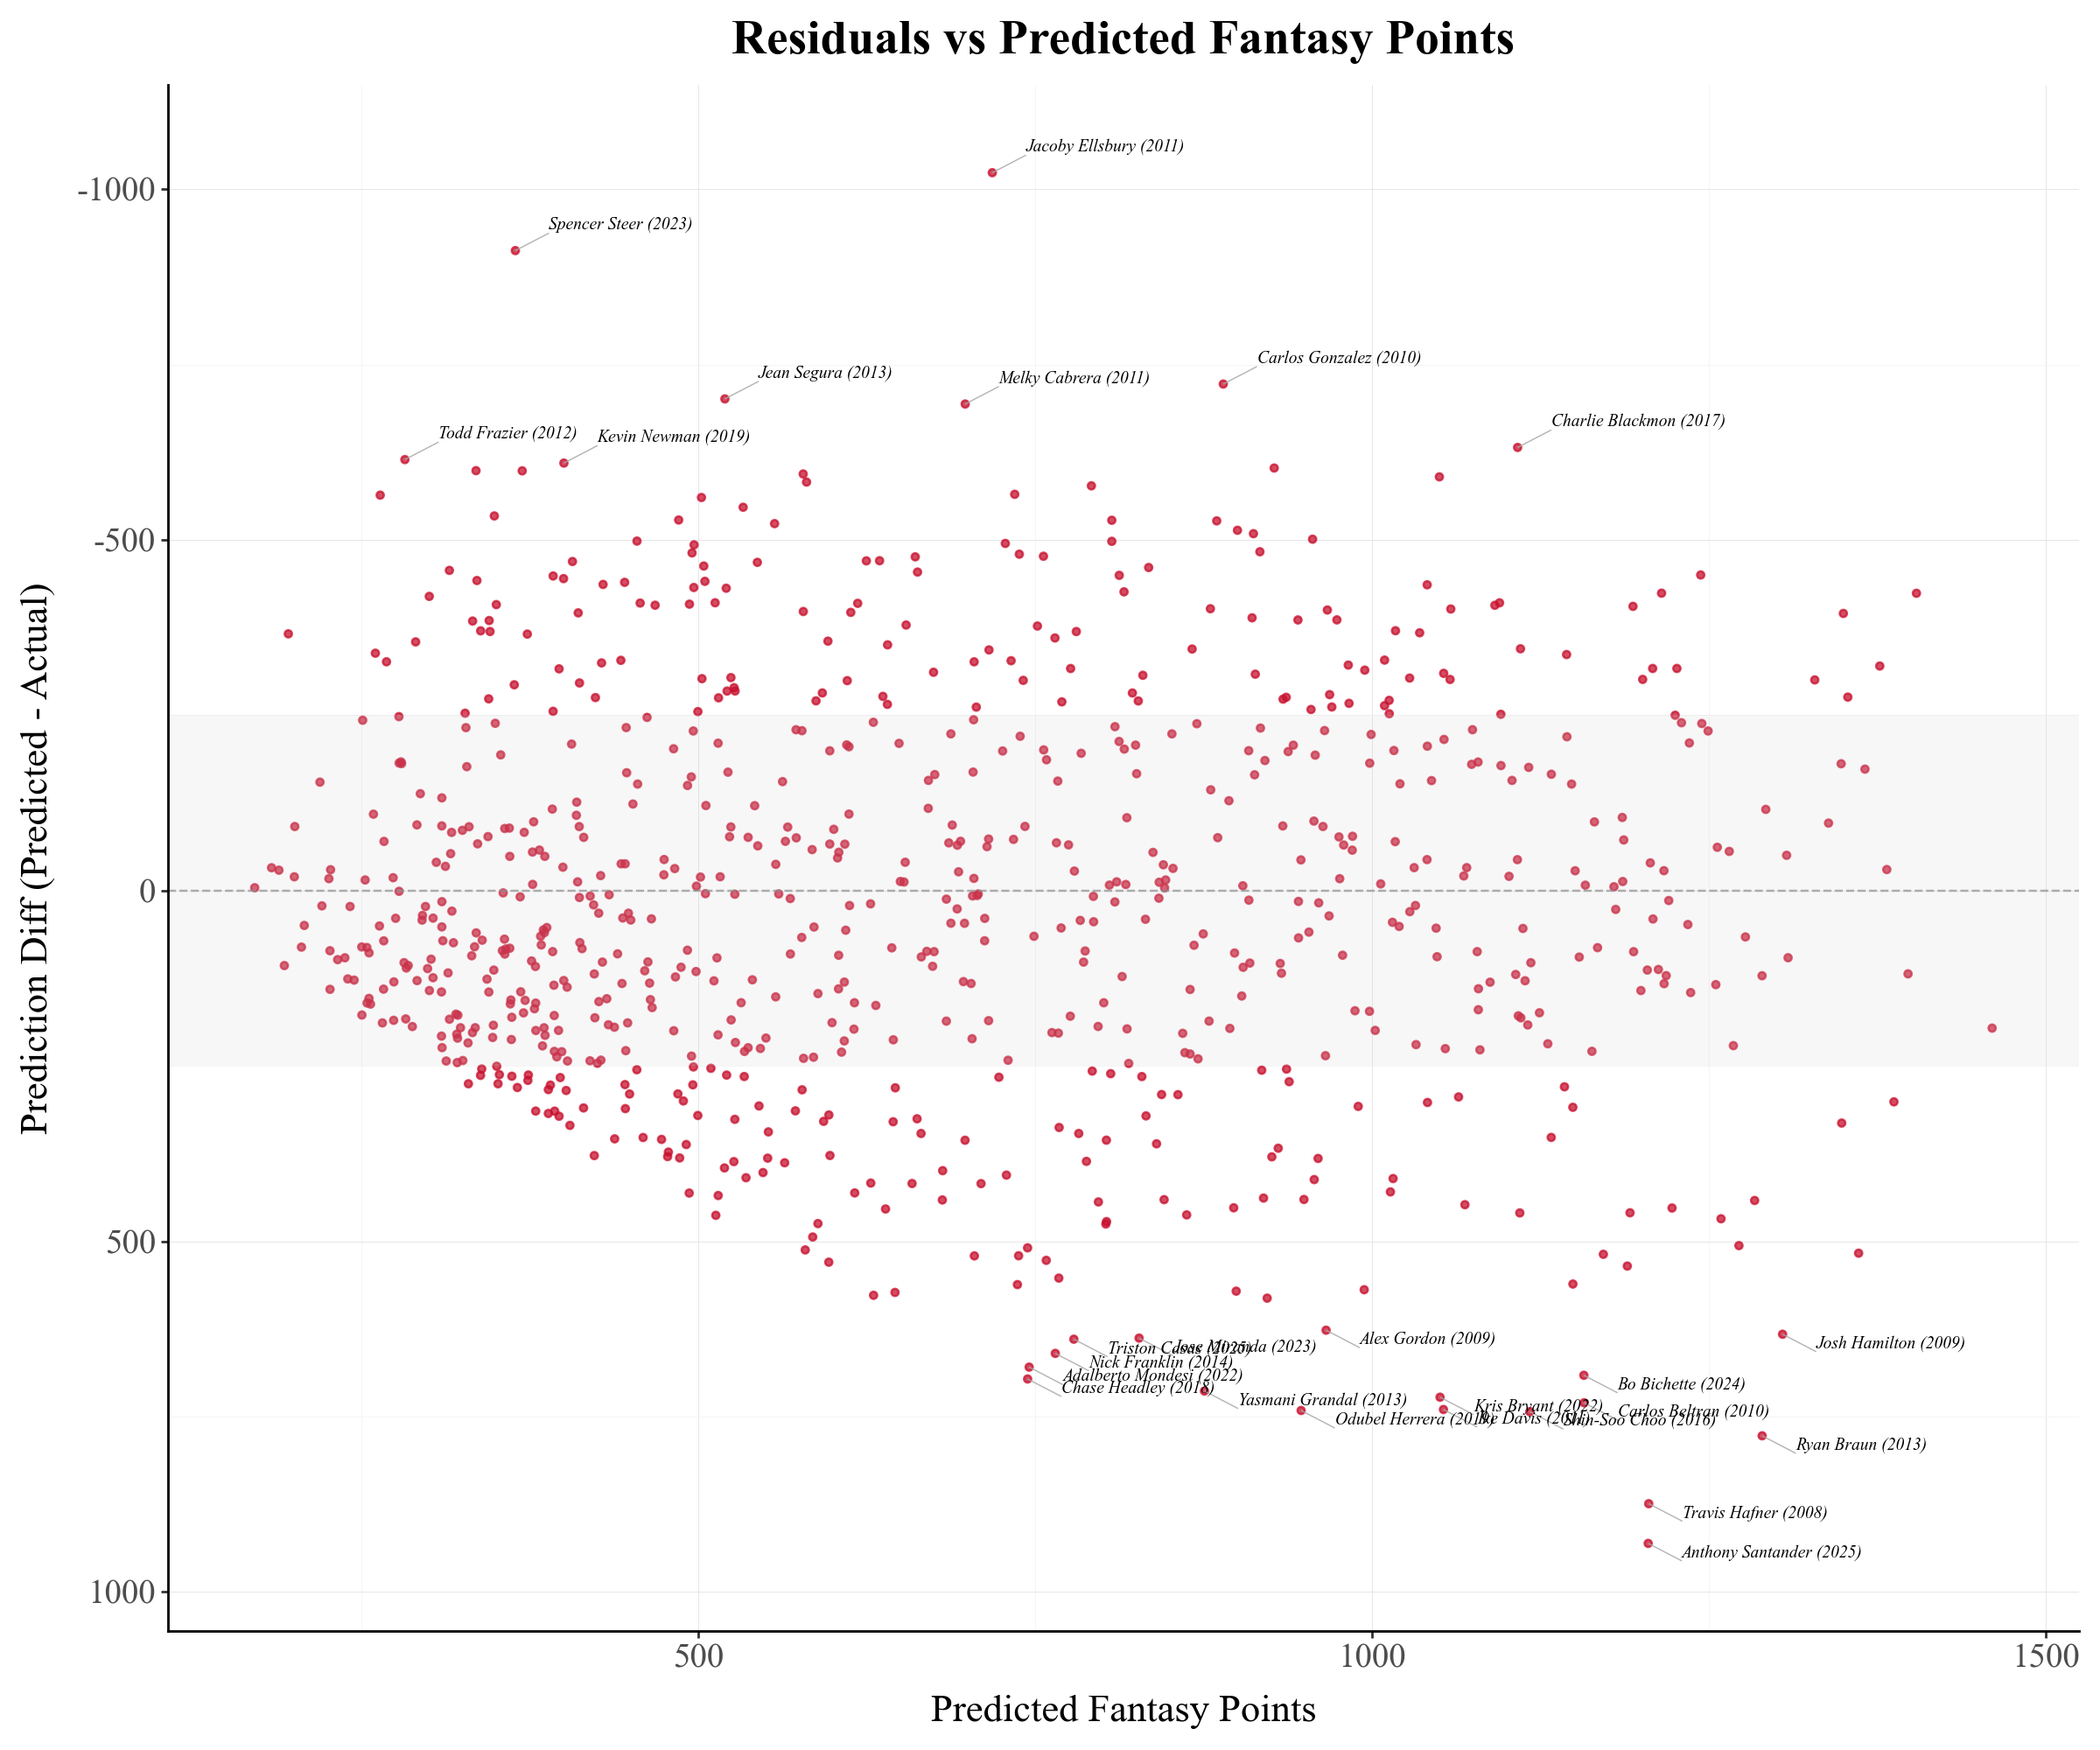

In [12]:
p2 = plot_resid_vs_pred_mlb(
    batting_results,
    band=250,
    top_n=25,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

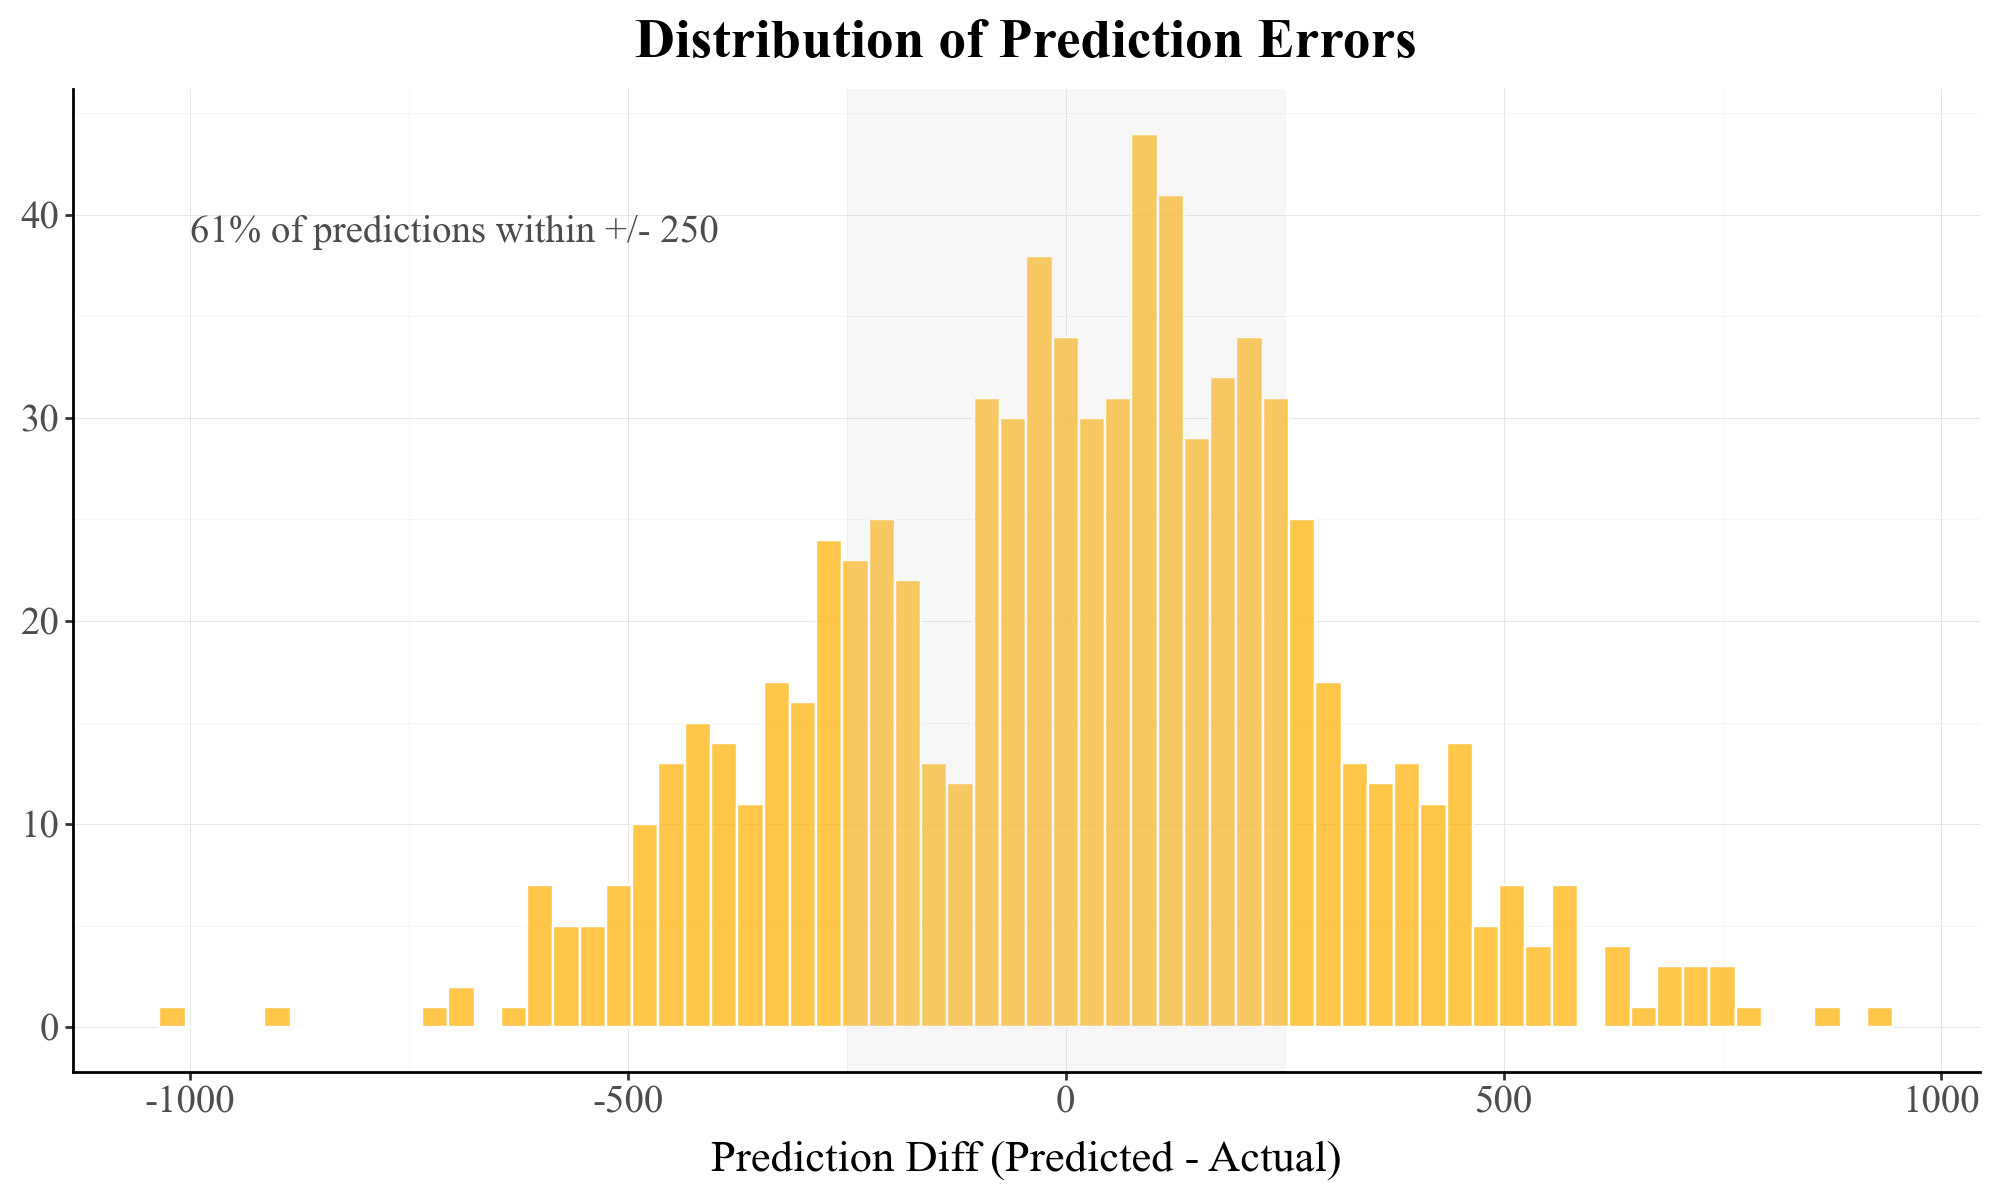

In [13]:
p3 = plot_resid_hist_mlb(
    batting_results,
    band=250,
    binwidth=30,
    x_annotate=-1000,    # custom annotation position
    y_annotate=40,      # custom annotation position
)
p3.show()

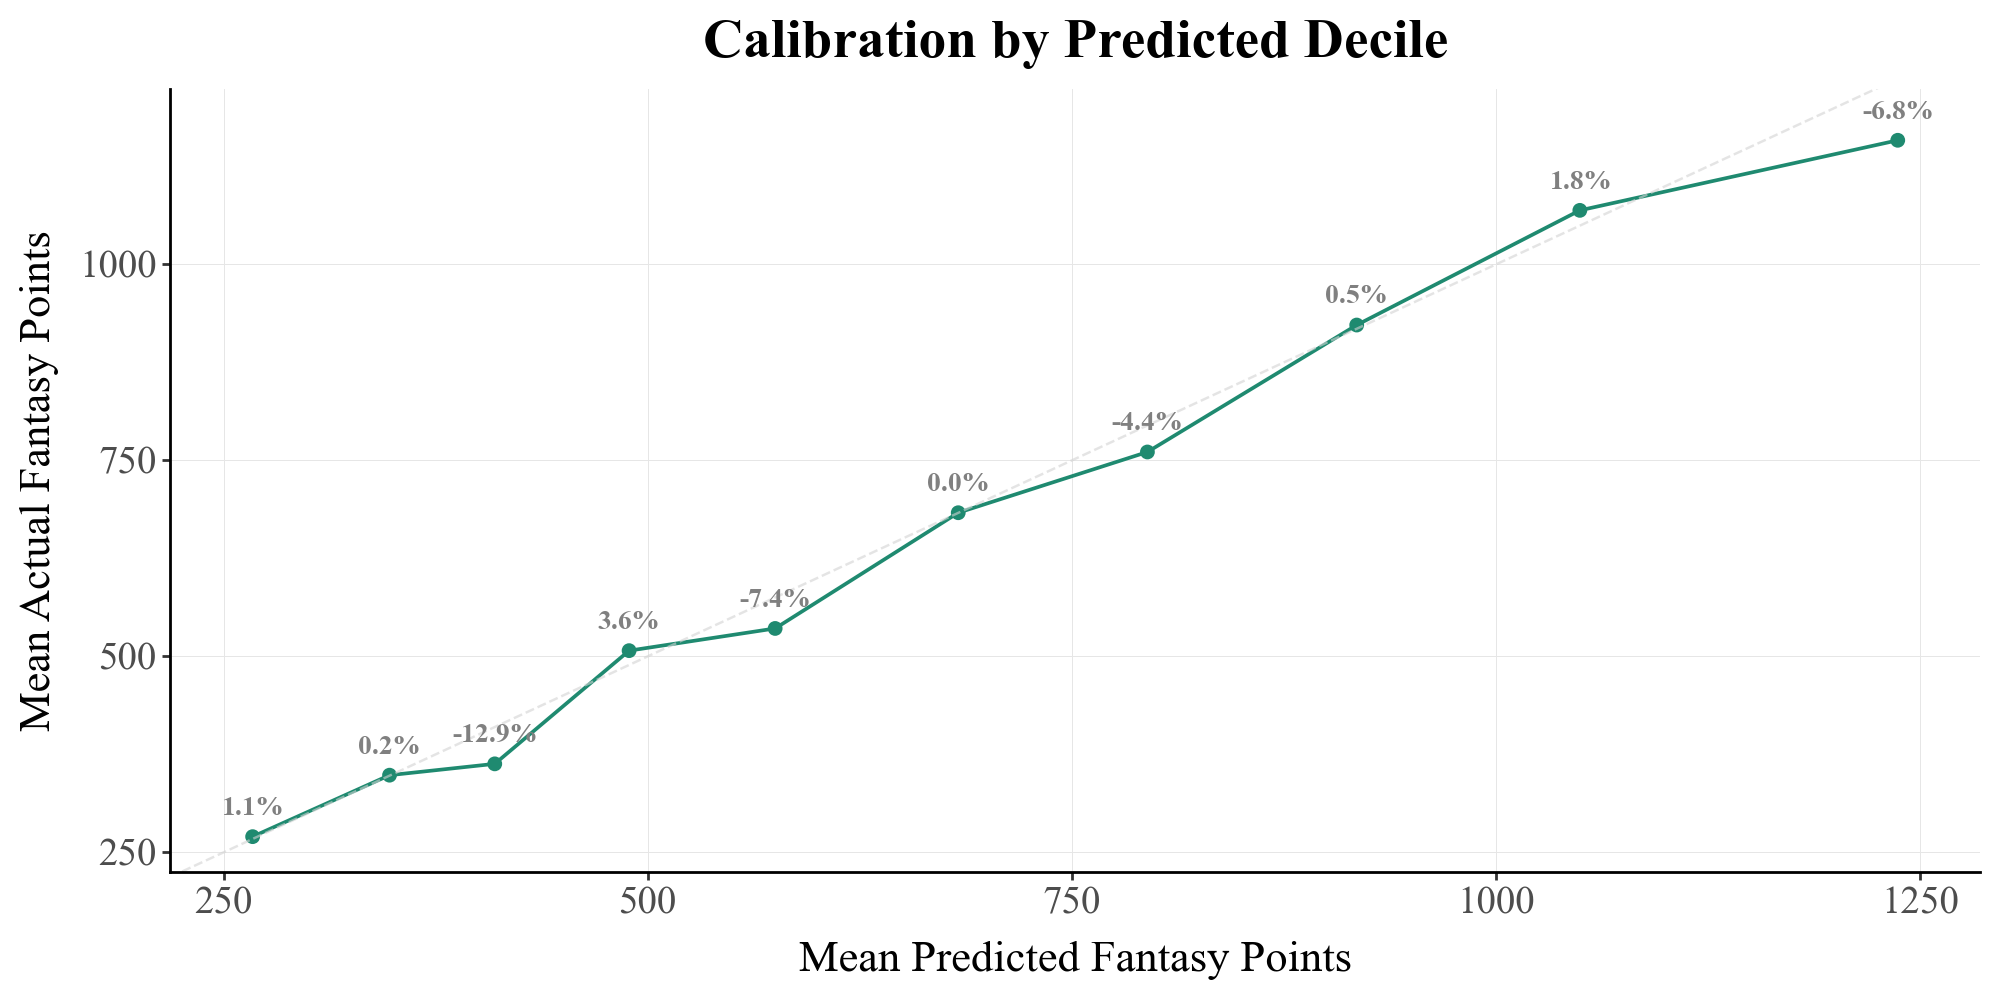

In [14]:
p4 = plot_decile_calib(batting_results)
p4.show()

# Creating Pitching Model

# Creating baseline pitching predictions

In [15]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data_random(pitching_df, random_state=SEED)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 120.227 | MAE: 88.241 | R^2: 0.444 | Spearman: 0.549


In [16]:
pitching_comp = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_comp.head(10))

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
316,Max Scherzer,877.525,773.025024,-104.499976,104.499976,2015,30,867.950
53,Chris Sale,669.100,690.556274,21.456274,21.456274,2013,24,697.825
556,Stephen Strasburg,455.575,689.688293,234.113293,234.113293,2014,25,726.150
302,Zack Wheeler,522.650,647.967224,125.317224,125.317224,2021,31,776.175
559,Jake Arrieta,632.475,636.733276,4.258276,4.258276,2015,29,880.350
393,Jake Peavy,596.725,595.156433,-1.568567,1.568567,2005,24,694.350
689,Mark Prior,58.000,592.079712,534.079712,534.079712,2005,24,536.850
117,Stephen Strasburg,726.150,585.462708,-140.687292,140.687292,2013,24,586.350
45,Felix Hernandez,754.050,573.651733,-180.398267,180.398267,2008,22,515.850
507,Chris Sale,548.175,569.639160,21.464160,21.464160,2018,29,713.500


# Pitching Predictions

In [17]:
# Tune model
best_params, best_iter = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=param_space,
    model_objective="reg:squarederror",
    metric="rmse",     
    evals=50,
    random_state=SEED,
    id_cols=["IDfg"],
)

# Generating prediction intervals via bootstrap-resampled models
pitching_intervals = generate_prediction_intervals(
    X_train=x_train,
    y_train=y_train,
    X_pred=pitching_pred.drop(columns=['fantasy_points_future']),
    base_params=best_params,
    model_objective="reg:squarederror",
    metric="rmse",
    n_bootstrap=40,
    random_state=SEED,
    id_cols=['IDfg', 'Name'],
    n_estimators=2000,
    early_stopping_rounds=100,
)

100%|██████████| 50/50 [03:14<00:00,  3.88s/trial, best loss: 115.76505672216022]
[Early stopping summary] mean=300, min=65, max=681
Best Parameters: {'learning_rate': 0.03096572025879217, 'max_leaves': 23, 'grow_policy': 'lossguide', 'subsample': 0.9373883622172821, 'colsample_bytree': 0.7420828738512325, 'min_child_weight': 0.3757973088268973, 'reg_lambda': 4.986220110672517, 'reg_alpha': 0.07991909040004126, 'gamma': 0.3018492439527742}
[Best trial @ val] optimized=rmse | RMSE=115.765 | MAE=87.313 | R^2=0.499 | SPEAR=0.598 


Bootstrapping prediction intervals: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


In [18]:
# Create final model
pitching_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    n_estimators=best_iter,
    model_objective="reg:squarederror",
    metric="rmse",
    random_state=SEED,
    id_cols=["IDfg"],          
)

[Test] RMSE: 117.442 | MAE: 87.174 | R^2: 0.470 | SPEAR: 0.558


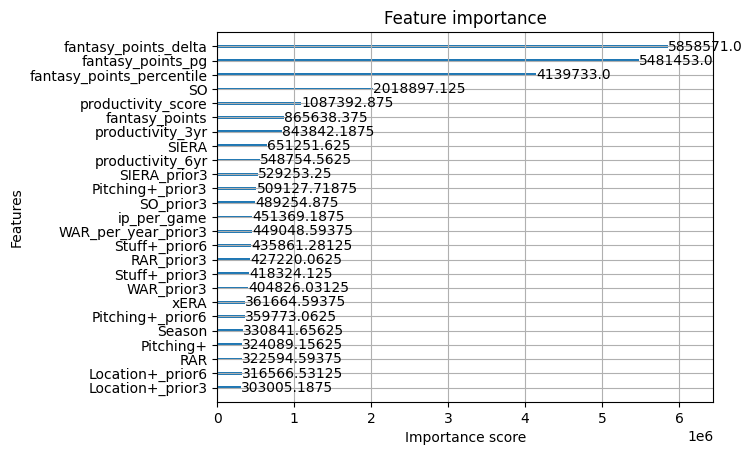

In [19]:
# Plot feature importance using XGBoost's built-in method
plot_importance(pitching_model, importance_type="gain", max_num_features=25)
plt.show()

In [20]:
pitching_results = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_results.head(10))

,Name,fantasy_points_future,predicted_fantasy_points,prediction_diff,absolute_diff,Season,Age,fantasy_points
316,Max Scherzer,877.525,721.216919,-156.308081,156.308081,2015,30,867.950
53,Chris Sale,669.100,708.822815,39.722815,39.722815,2013,24,697.825
556,Stephen Strasburg,455.575,641.561035,185.986035,185.986035,2014,25,726.150
507,Chris Sale,548.175,638.536377,90.361377,90.361377,2018,29,713.500
393,Jake Peavy,596.725,637.275391,40.550391,40.550391,2005,24,694.350
302,Zack Wheeler,522.650,618.361694,95.711694,95.711694,2021,31,776.175
559,Jake Arrieta,632.475,604.254883,-28.220117,28.220117,2015,29,880.350
111,Clayton Kershaw,508.475,592.601929,84.126929,84.126929,2017,29,682.650
348,James Shields,685.500,581.180542,-104.319458,104.319458,2011,29,796.975
280,Clayton Kershaw,865.375,579.165344,-286.209656,286.209656,2010,22,659.425


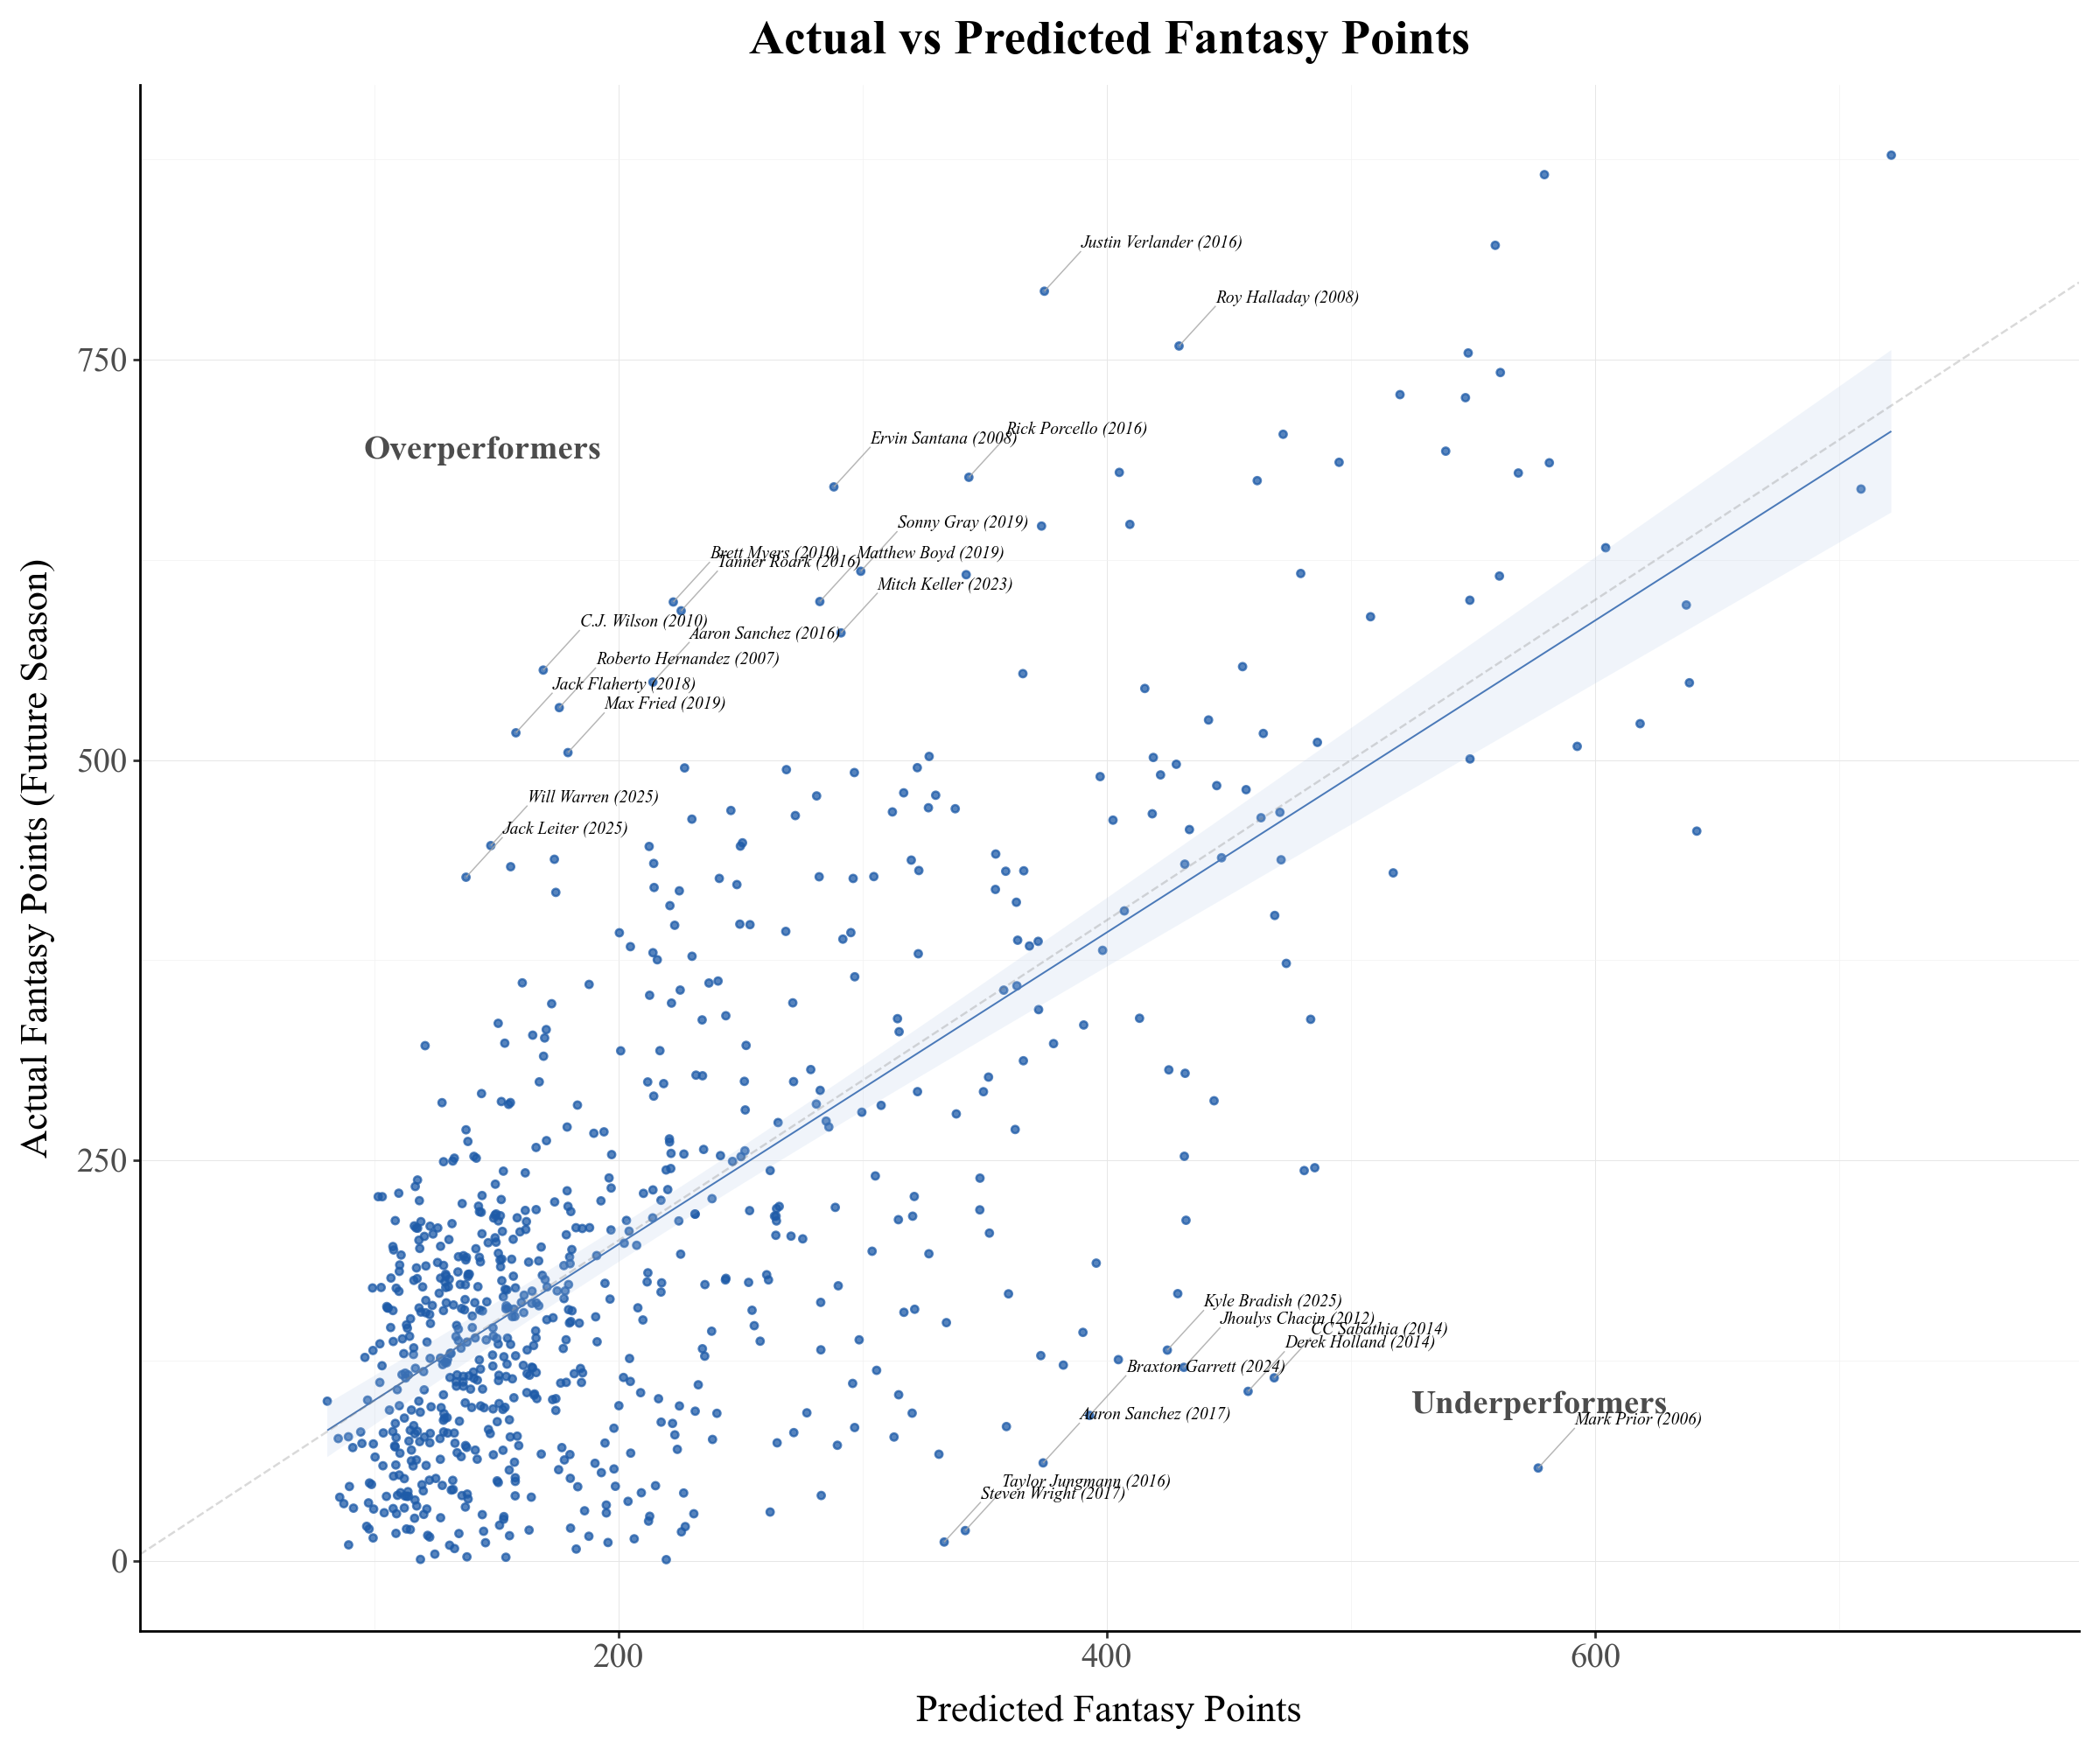

In [21]:
p1 = plot_actual_vs_pred_mlb(
    pitching_results,
    top_n=25,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

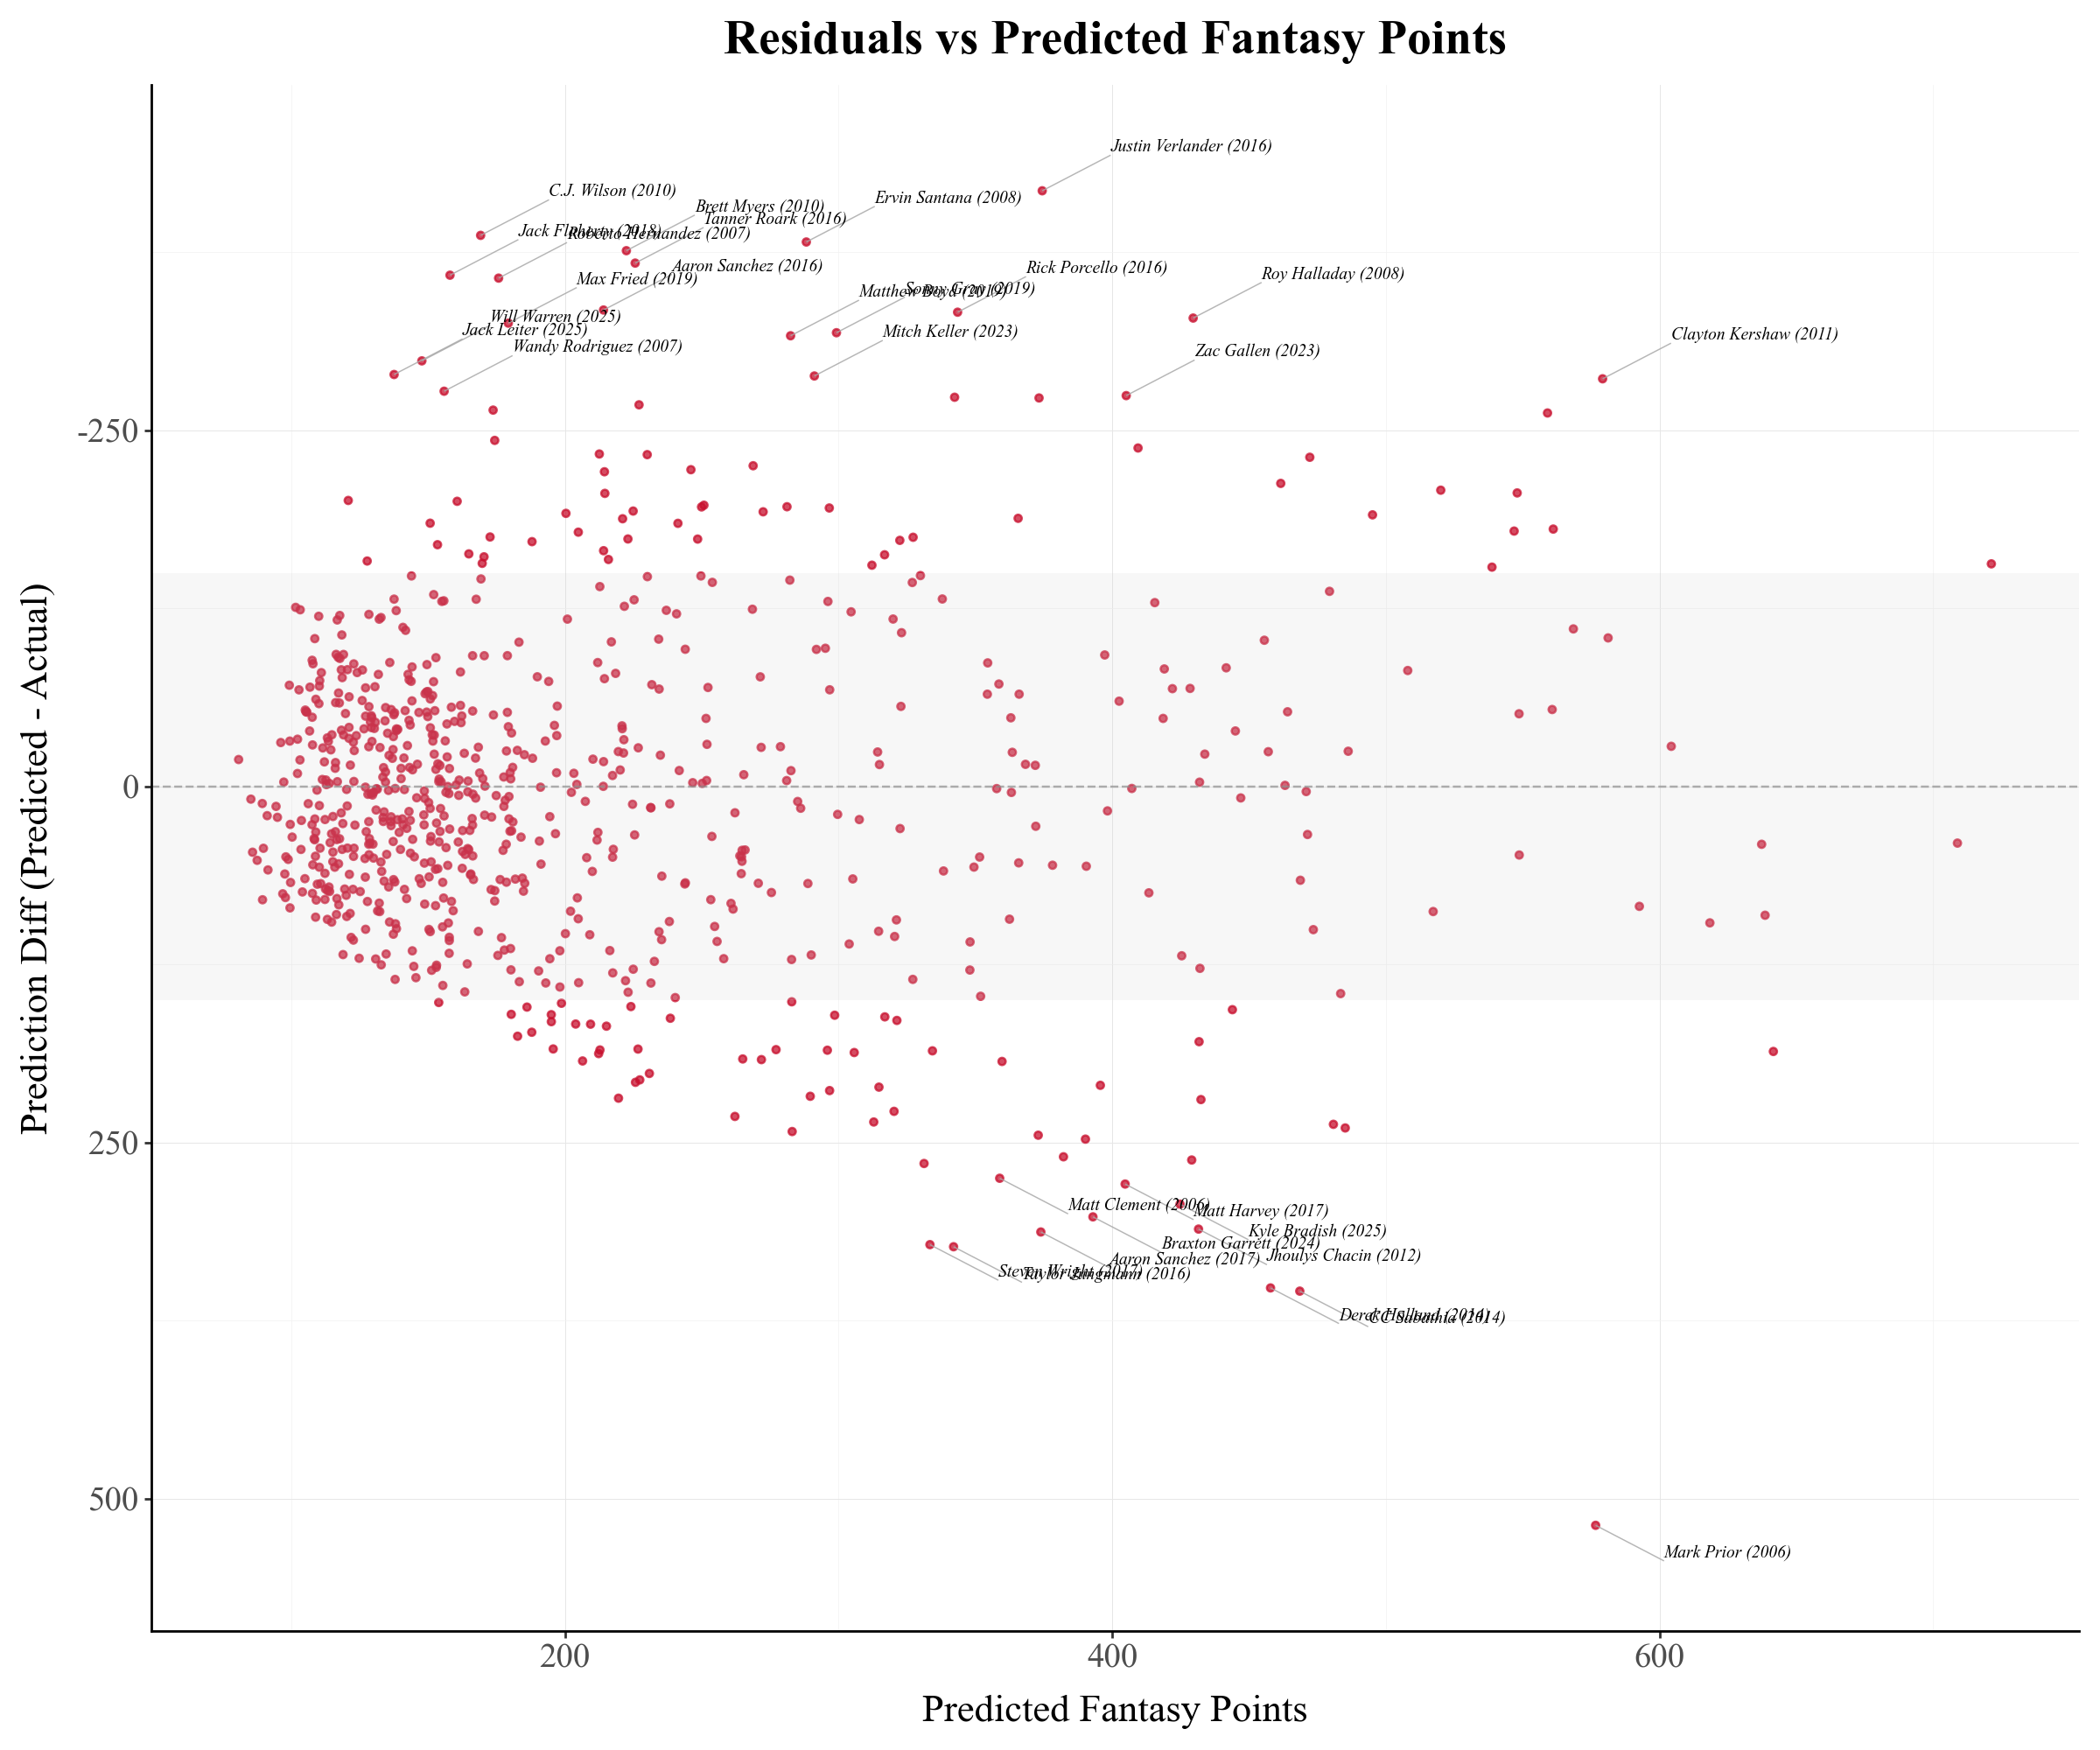

In [22]:
p2 = plot_resid_vs_pred_mlb(
    pitching_results,
    band=150,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

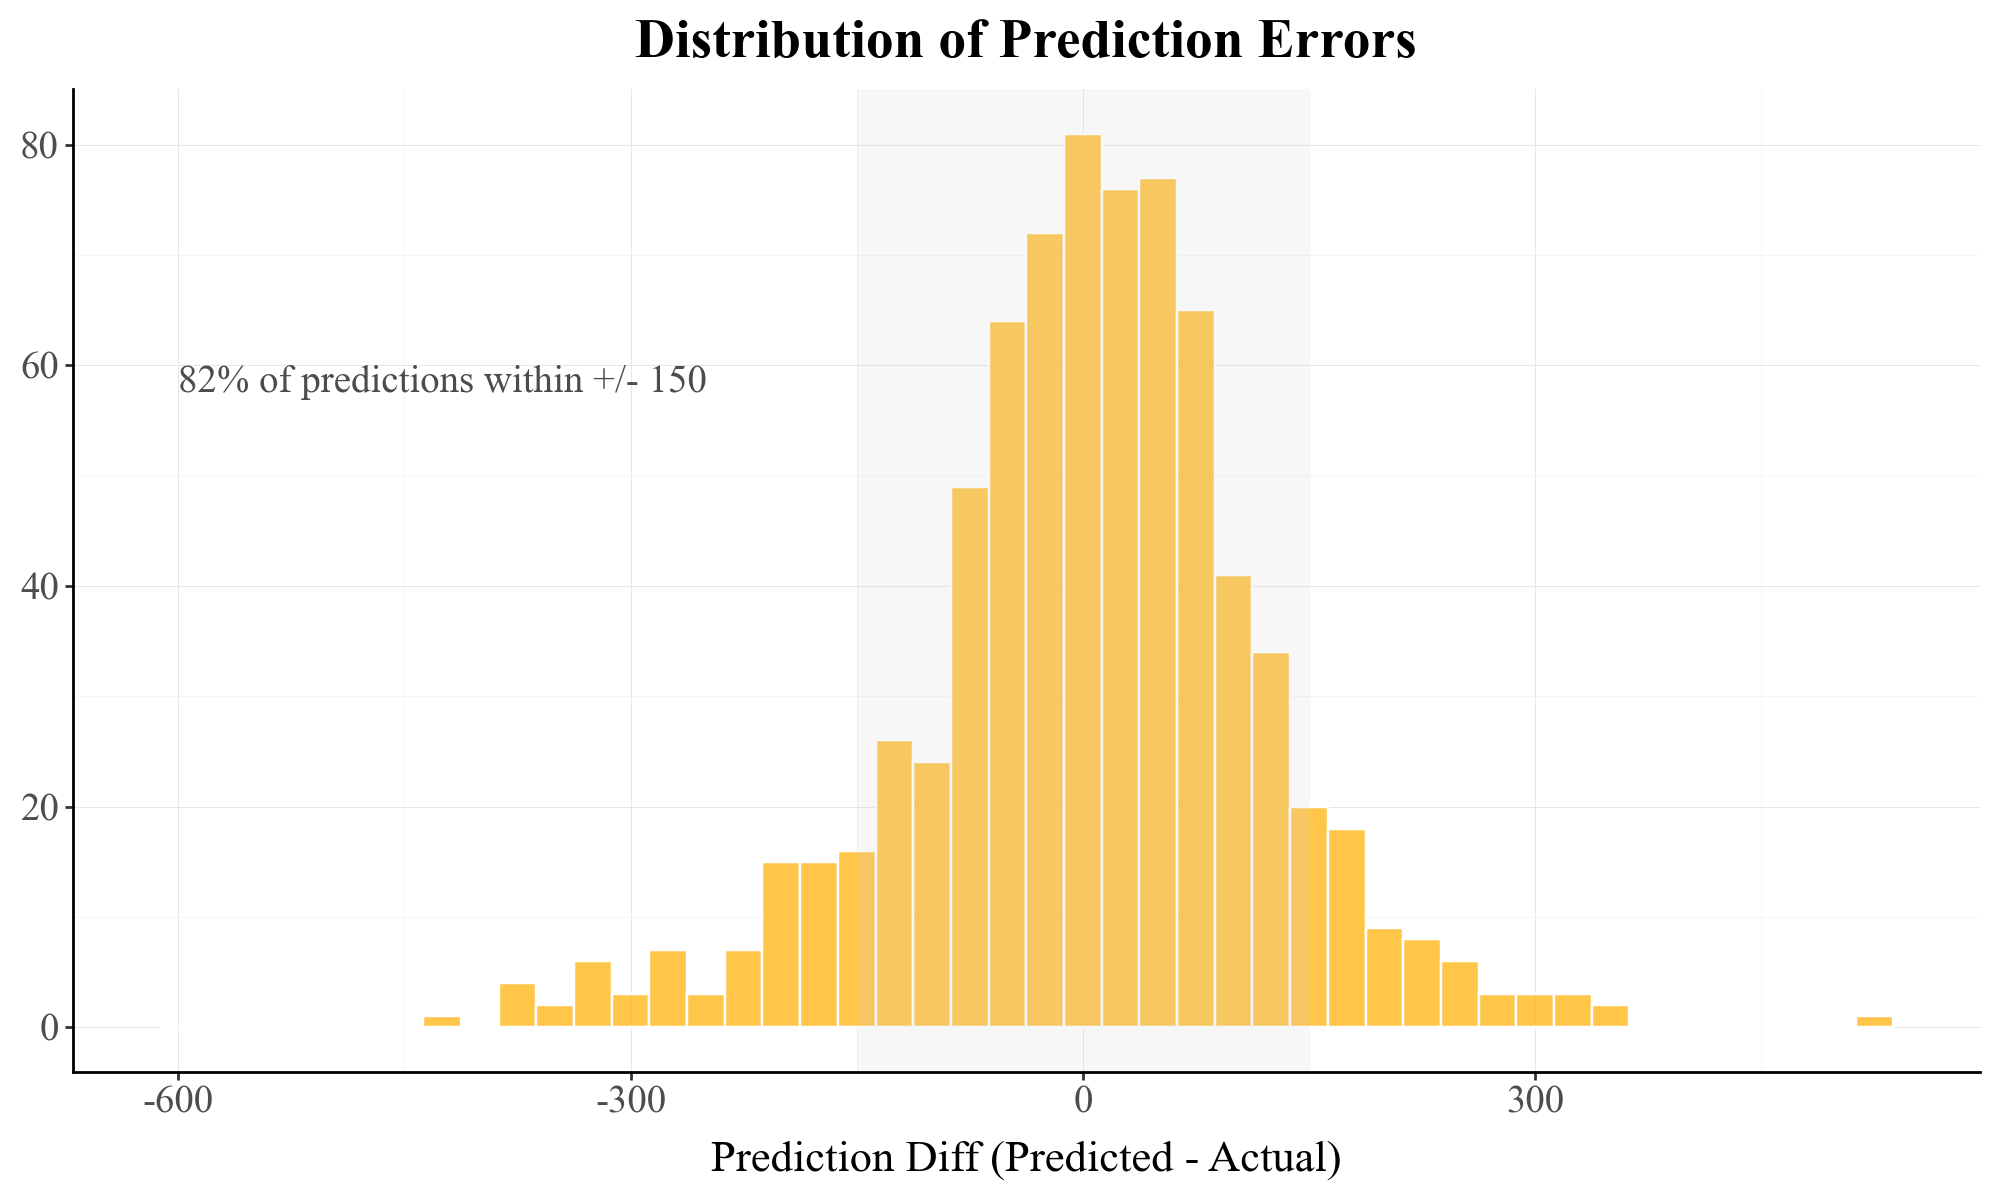

In [23]:
p3 = plot_resid_hist_mlb(
    pitching_results,
    band=150,
    binwidth=25,
    x_annotate=-600,    # custom annotation position
    y_annotate=60,      # custom annotation position
)
p3.show()

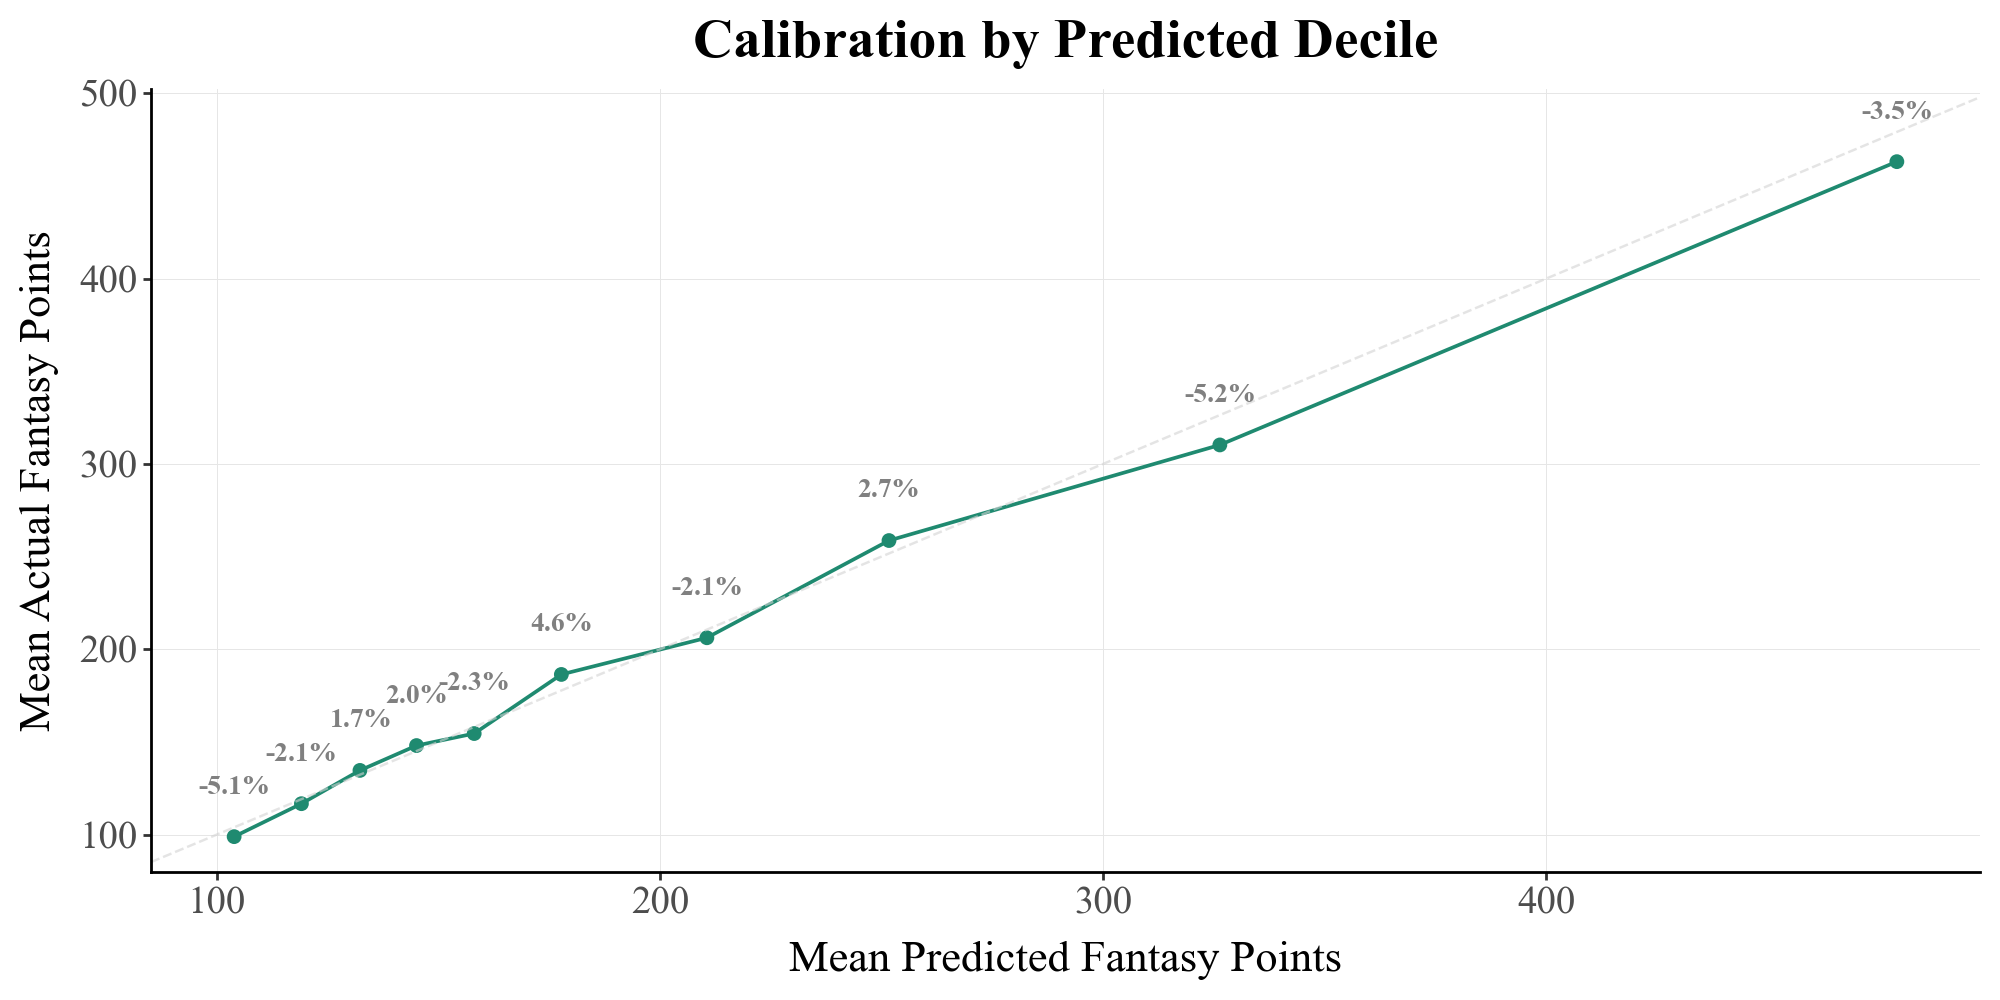

In [24]:
p4 = plot_decile_calib(pitching_results)
p4.show()

# Predicting Upcoming Season Player Performance

In [25]:
# Dropping fantasy_points_future from prediction dataframes
batting_pred = batting_pred.drop(columns=['fantasy_points_future'])
pitching_pred = pitching_pred.drop(columns=['fantasy_points_future'])

# Making predictions for the upcoming season
batting_pred['fantasy_points_pred'] = batting_model.predict(batting_pred.drop(columns=['IDfg', 'Name']))
pitching_pred['fantasy_points_pred'] = pitching_model.predict(pitching_pred.drop(columns=['IDfg', 'Name']))

# Merge intervals onto pred dataframes
batting_pred = batting_pred.merge(
    batting_intervals[['IDfg', 'pred_mean', 'pred_p10', 'pred_p50', 'pred_p90', 'pred_upside', 'pred_downside', 'implied_upside', 'pred_width_80']],
    on='IDfg',
    how='left'
)

pitching_pred = pitching_pred.merge(
    pitching_intervals[['IDfg', 'pred_mean', 'pred_p10', 'pred_p50', 'pred_p90', 'pred_upside', 'pred_downside', 'implied_upside', 'pred_width_80']],
    on='IDfg',
    how='left'
)

batting_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)
pitching_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)

In [26]:
display(batting_pred.head(5))

,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,...,player_tier_recent,fantasy_points_pred,pred_mean,pred_p10,pred_p50,pred_p90,pred_upside,pred_downside,implied_upside,pred_width_80
203,19755,2025,Shohei Ohtani,30,158,611,172,83,25,9,...,star,1646.543213,1411.998549,918.952329,1367.921812,1843.867422,431.868873,493.046220,0.828468,924.915093
92,15640,2025,Aaron Judge,33,152,541,179,94,30,2,...,star,1579.859009,1170.610982,811.315435,1119.434910,1604.407093,433.796111,359.295547,1.133492,793.091658
228,20123,2025,Juan Soto,26,160,577,152,88,20,1,...,star,1577.142944,1466.011808,1051.138321,1481.101174,1887.156908,421.145100,414.873487,0.948111,836.018587
59,13510,2025,Jose Ramirez,32,158,593,168,101,34,3,...,star,1479.892090,1349.155124,974.079874,1360.995688,1621.198240,272.043116,375.075250,0.676626,647.118367
373,25878,2025,Corbin Carroll,24,143,564,146,66,32,17,...,star,1440.270386,1290.842002,1000.822697,1311.119424,1555.653198,264.811196,290.019305,0.838445,554.830501


In [27]:
display(pitching_pred.head(5))

,IDfg,Season,Name,Age,G,GS,Pitches,Strikes,W,WAR,...,is_reliever,fantasy_points_pred,pred_mean,pred_p10,pred_p50,pred_p90,pred_upside,pred_downside,implied_upside,pred_width_80
186,17995,2025,Logan Webb,28,34,34,3282,2165,15,5.5,...,0,554.703064,570.648266,478.398231,571.572134,671.939747,101.291481,92.250036,0.977123,193.541516
444,27463,2025,Garrett Crochet,26,32,32,3151,2114,18,5.8,...,0,545.416748,557.662194,438.339652,546.830113,721.963125,164.300931,119.322541,1.259245,283.623472
335,22267,2025,Tarik Skubal,28,31,31,2849,2003,13,6.6,...,0,538.128174,567.403734,456.830309,577.691059,696.048937,128.645204,110.573425,1.055148,239.218629
279,20778,2025,Cristopher Sanchez,28,32,32,2897,1941,13,6.4,...,0,522.225708,515.700473,408.052834,517.369824,630.138563,114.438090,107.647639,0.970130,222.085729
248,19959,2025,Jesus Luzardo,27,32,32,3015,1955,15,5.3,...,0,514.505615,491.078857,361.677382,492.775489,646.459094,155.380237,129.401475,1.116053,284.781712


In [28]:
# Splitting names into first and last
batting_pred = split_name(batting_pred, 'Name')
pitching_pred = split_name(pitching_pred, 'Name')

# Creating combined batting dataframe
batting_final = combine_projections(batting_pred, batting_projections)

Duplicate rows found:


,IDfg,Season,Name,Age,G,AB,H,1B,2B,3B,...,pred_p90,pred_upside,pred_downside,implied_upside,pred_width_80,first_name,last_name,Team,Positions,projected_fantasy_points
509,13301.0,2025.0,Max Muncy,34.0,100.0,313.0,76.0,45.0,10.0,2.0,...,1233.448107,371.668879,349.934243,1.012253,721.603122,max,muncy,LAD,3B,821.0
510,13301.0,2025.0,Max Muncy,34.0,100.0,313.0,76.0,45.0,10.0,2.0,...,1233.448107,371.668879,349.934243,1.012253,721.603122,max,muncy,ATH,"2B,3B,SS",591.0
511,29779.0,2025.0,Max Muncy,22.0,63.0,206.0,44.0,28.0,7.0,0.0,...,803.156717,311.978339,327.897821,0.923774,639.876161,max,muncy,LAD,3B,821.0
512,29779.0,2025.0,Max Muncy,22.0,63.0,206.0,44.0,28.0,7.0,0.0,...,803.156717,311.978339,327.897821,0.923774,639.876161,max,muncy,ATH,"2B,3B,SS",591.0


In [29]:
# Filter the batting_final DataFrame to drop rows where Name is "Max Muncy" and projected_fantasy_points < 750
batting_final = batting_final[~((batting_final['Name'] == 'Max Muncy') & (batting_final['projected_fantasy_points'] < 750))]

In [30]:
# Creating combined pitching dataframe
pitching_final = combine_projections(pitching_pred, pitching_projections)

Duplicate rows found:


,IDfg,Season,Name,Age,G,GS,Pitches,Strikes,W,WAR,...,pred_p90,pred_upside,pred_downside,implied_upside,pred_width_80,first_name,last_name,Team,Positions,projected_fantasy_points
594,6984.0,2025.0,Luis Garcia,38.0,58.0,0.0,896.0,572.0,2.0,0.7,...,229.798326,135.567982,142.071885,0.941729,277.639867,luis,garcia,NYM,RP,144.5
595,6984.0,2025.0,Luis Garcia,38.0,58.0,0.0,896.0,572.0,2.0,0.7,...,229.798326,135.567982,142.071885,0.941729,277.639867,luis,garcia,NaN,SP,93.4


In [31]:
# # Filter the pitching_final DataFrame to drop rows where Name is Luis Garcia and position is not RP
pitching_final = pitching_final[~((pitching_final['Name'].isin(['Luis Garcia'])) & (pitching_final['Positions'] != 'RP'))]

# Finalizing Predictions & Creating Relative Positional Value Scores

In [ ]:
# Suppress the SettingWithCopyWarning while updating player names
pd.options.mode.chained_assignment = None  # default='warn'

# Assigning position groups, cleaning player names, combining projections, and selecting final columns
batting_final = finalize_predictions(
    batting_final,
    mode="bat",
    position_overrides=BAT_POS_OVERRIDES,
)
pitching_final = finalize_predictions(
    pitching_final,
    mode="pit",
)

# Splitting the batters into infielders and outfielders
batting_final_if, batting_final_of = split_batters_if_of(batting_final)

In [33]:
# Adjusting positional group for select players within the batting_final dataframe to align with 2026 position designations
batting_final.loc[batting_final['Name'] == 'Shohei Ohtani', 'Position'] = 'OF'
batting_final.loc[batting_final['Name'] == 'Rafael Devers', 'Position'] = 'OF'
batting_final.loc[batting_final['Name'] == 'Tyler Soderstrom', 'Position'] = 'OF'

# Splitting batting players into infielders and outfielders
batting_final_if = batting_final[batting_final['Position'] != 'OF']
batting_final_of = batting_final[batting_final['Position'] == 'OF']

# Replace NULL values in the prediction column with values from the projected column and vice versa
batting_final['fantasy_points_pred'] = batting_final['fantasy_points_pred'].fillna(batting_final['projected_fantasy_points'])
batting_final['projected_fantasy_points'] = batting_final['projected_fantasy_points'].fillna(batting_final['fantasy_points_pred'])

pitching_final['fantasy_points_pred'] = pitching_final['fantasy_points_pred'].fillna(pitching_final['projected_fantasy_points'])
pitching_final['projected_fantasy_points'] = pitching_final['projected_fantasy_points'].fillna(pitching_final['fantasy_points_pred'])

In [34]:
# Creating final projected score, with a blended weight combining model and expert projections
# Creating initial player rankings based on final projection
# Filtering to player pool based on position
batting_final_if = (
    batting_final_if
    .pipe(
        create_draft_pool,
        model_weight=MODEL_WEIGHT,
        projection_weight=PROJECTION_WEIGHT,
        rank_cutoff=batter_pool_if,
    )
)

batting_final_of = (
    batting_final_of
    .pipe(
        create_draft_pool,
        model_weight=MODEL_WEIGHT,
        projection_weight=PROJECTION_WEIGHT,
        rank_cutoff=batter_pool_of,
    )
)

pitching_final = (
    pitching_final
    .pipe(
        create_draft_pool,
        model_weight=MODEL_WEIGHT,
        projection_weight=PROJECTION_WEIGHT,
        rank_cutoff=pitcher_pool,
    )
)

batting_final = pd.concat([batting_final_if, batting_final_of])

# Assigning player position groups
batting_final = assign_position_group(batting_final, position_col = 'Position')
pitching_final = assign_position_group(pitching_final, position_col = 'Position')

# Combine dataframes into a complete dataframe containing batters and hitters
combined_df = pd.concat([batting_final, pitching_final])

# Setting missing values in the implied_upside column to 1
combined_df['implied_upside'] = combined_df['implied_upside'].fillna(1)

In [35]:
# Calculating relative positional values & ranking players within position based on projected value
value_df = calculate_relative_value(
    df=combined_df,
    position_col="position_group",
    projection_col="final_projection",
    vorp_cutoff=0.67,
    vorp_scale=1, # VORP scale set to 1, see validation within "estimate_vorp_scale.ipynb"
    dampening_map=POS_DAMPENING_MAP,
)

# Saving value_df to CSV for vorp_scale estimation
# value_df.to_csv('notebooks/value_df.csv', index=False)

# Create Player Value Segments

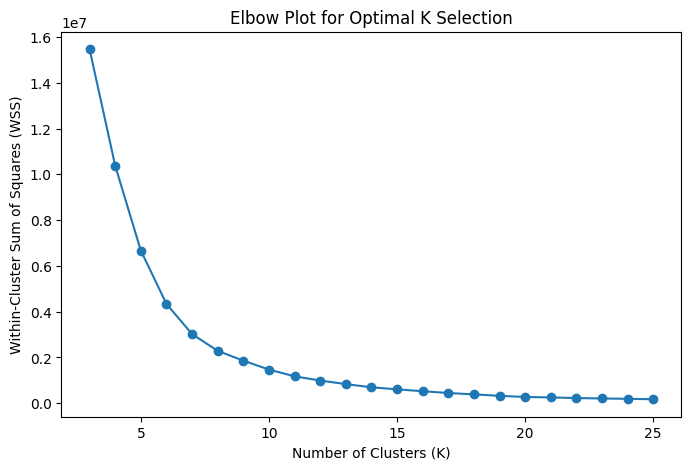

In [36]:
# Evaluating clustering performance on varying K values
determine_optimal_k(value_df, max_k = 25)

In [37]:
# Setting a K value and placing players into relative value tiers
final_df = segment_players(value_df, k = 20)

In [38]:
# Sorting final dataframe based on relative value, player value tier & position rank
final_df = final_df.sort_values(by = ['relative_value', 'player_value_tier', 'position_rank'], ascending = False)

# Selecting final columns for output
final_df = final_df[['Name', 'Age', 'Team', 'Position', 'position_group', 'fantasy_points_pred', 'projected_fantasy_points', 
                     'final_projection', 'pred_downside', 'pred_upside', 'implied_upside', 'relative_value',  
                     'overall_ranking', 'position_rank', 'player_value_tier']]

In [39]:
# Saving out final dataframe
final_df.to_csv(f'data/predictions_{datetime.now().strftime('%Y-%m-%d')}_{FORMAT}.csv', index=False)